In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import re
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# ts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller

#stat & plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\cuiti\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df=pd.read_csv('gun_cleaned2.csv')
df['date'] = pd.to_datetime(df['date'])
df['dayofweek']=df['date'].map(lambda x:x.dayofweek)

In [3]:
df2_idx_date=df.set_index('date')
df2_idx_date=df2_idx_date['2013-12-31':]

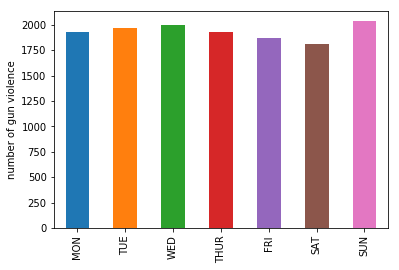

In [4]:
dayofweek_count=df2_idx_date.dayofweek.value_counts().sort_index()
S=Series(['MON','TUE','WED','THUR','FRI','SAT','SUN'])
dayofweek_count.index=S
dayofweek_count.plot(kind='bar')
ylabel('number of gun violence')
plt.savefig('weekday.png')

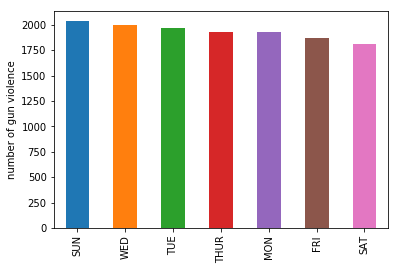

In [5]:
dayofweek_count.sort_values(ascending=False).plot(kind='bar')
ylabel('number of gun violence')
plt.savefig('weekday_order.png')

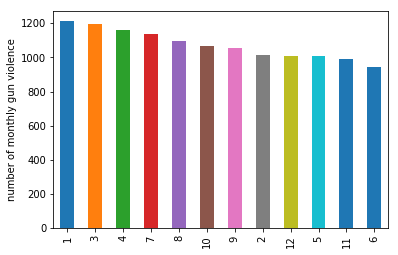

In [6]:
df2_idx_date_no18=df2_idx_date[:'2017-12-31']
df2_idx_date_no18.month.value_counts().sort_values(ascending=False).plot(kind='bar')
ylabel('number of monthly gun violence')
plt.savefig('month_order.png')

266.0
date
2014-01    327
2014-02    202
2014-03    219
2014-04    264
2014-05    219
2014-06    262
2014-07    316
2014-08    277
2014-09    258
2014-10    281
2014-11    242
2014-12    266
2015-01    281
2015-02    249
2015-03    286
2015-04    277
2015-05    271
2015-06    269
2015-07    279
2015-08    302
2015-09    294
2015-10    266
2015-11    254
2015-12    248
2016-01    288
2016-02    268
2016-03    346
2016-04    323
2016-05    286
2016-06    252
2016-07    308
2016-08    321
2016-09    312
2016-10    303
2016-11    289
2016-12    310
2017-01    318
2017-02    295
2017-03    345
2017-04    297
2017-05    233
2017-06    161
2017-07    232
2017-08    195
2017-09    190
2017-10    215
2017-11    207
2017-12    187
2018-01    237
2018-02    222
2018-03    217
Freq: M, Name: count, dtype: int64


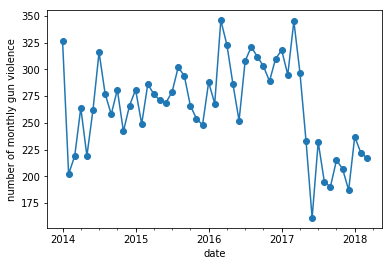

In [7]:
df2_idx_date['count']=1
y_count=df2_idx_date['count'].resample('M',kind='period').sum()
print(y_count.mean())
print(y_count)
y_count.plot(Marker='o')
ylabel('number of monthly gun violence')
plt.savefig('month.png')

798.0
date
2014Q1    748
2014Q2    745
2014Q3    851
2014Q4    789
2015Q1    816
2015Q2    817
2015Q3    875
2015Q4    768
2016Q1    902
2016Q2    861
2016Q3    941
2016Q4    902
2017Q1    958
2017Q2    691
2017Q3    617
2017Q4    609
2018Q1    676
Freq: Q-DEC, Name: count, dtype: int64


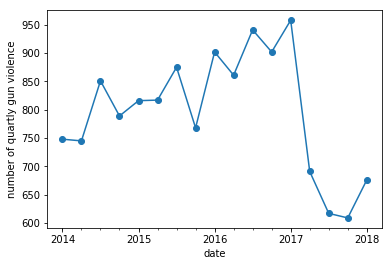

In [8]:
y_count=df2_idx_date['count'].resample('Q',kind='period').sum()
print(y_count.mean())
y_count.plot(Marker='o')
print(y_count)
ylabel('number of quartly gun violence')
plt.savefig('quarter.png')

date
2014    3133
2015    3276
2016    3606
2017    2875
2018     676
Freq: A-DEC, Name: count, dtype: int64


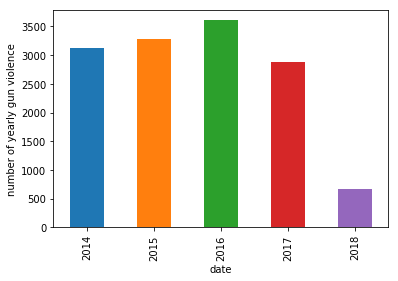

In [9]:
y_count=df2_idx_date['count'].resample('Y',kind='period').sum()
print(y_count)
y_count.plot(kind='bar')
ylabel('number of yearly gun violence')
plt.savefig('year.png')

In [10]:
# Get timeseries
ts_M = df2_idx_date['count'].resample('M',kind='period').sum()

In [11]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis. Data is non-stationary ")
        
adf_check(ts_M)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.570801103993506
p-value : 0.006344419701598502
#Lags Used : 0
Number of Observations Used : 50
strong evidence against the null hypothesis. Data is stationary


<Figure size 432x288 with 0 Axes>

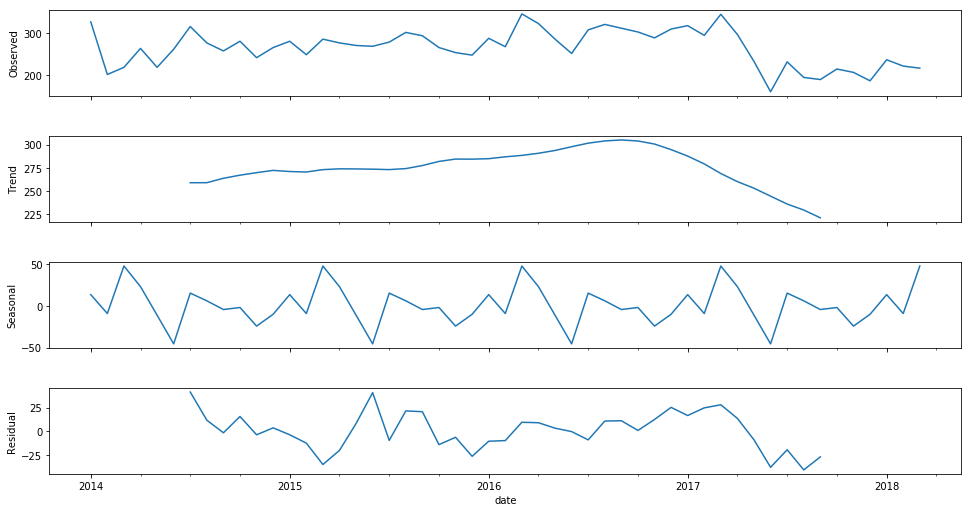

In [12]:
decomposition = seasonal_decompose(ts_M, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.savefig('decompose.png')

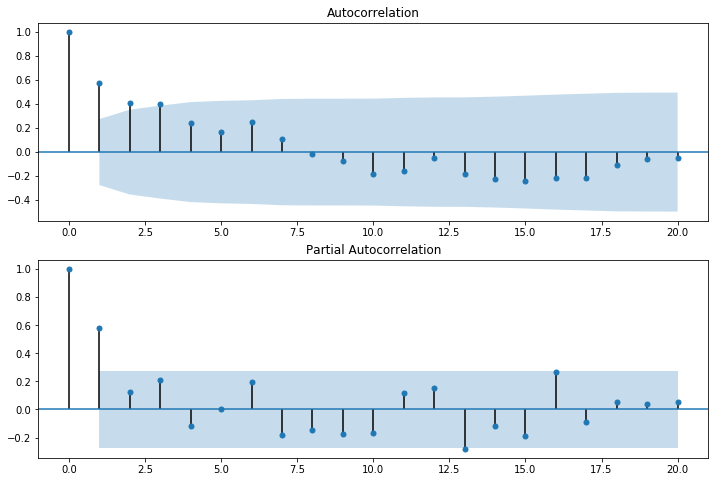

In [13]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_M,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_M,lags=20,ax=ax2)
plt.savefig('acf.png')

In [14]:
arma_mod = sm.tsa.ARMA(ts_M,(1,0)).fit() #second best
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)
arma_mod = sm.tsa.ARMA(ts_M,(0,1)).fit()
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)
arma_mod = sm.tsa.ARMA(ts_M,(0,0)).fit()
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)
arma_mod = sm.tsa.ARMA(ts_M,(1,1)).fit()
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)
arma_mod = sm.tsa.statespace.SARIMAX(ts_M, trend='c', order=(1,0,0), seasonal_order=(1,0,0,12)).fit() #best
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)

512.351278673 518.1467555707923 514.5659018062546
517.058179234 522.8536561319474 519.2728023674098
531.8495496699963 535.713200935445 533.3259650924199
513.663488117 521.3907906481573 516.6163189621071
508.5603947181202 516.2876972490175 511.5132255629672


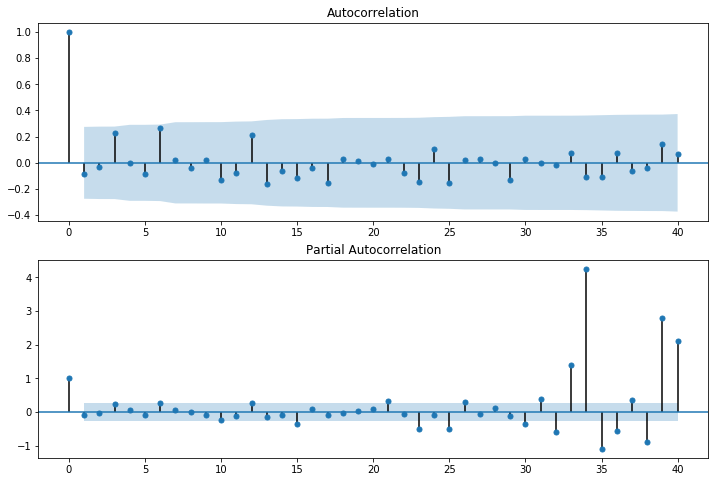

In [15]:
m_arma=sm.tsa.ARMA(ts_M,(1,0)).fit()
res=m_arma.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res, lags=40, ax=ax2)

2.1038679569471332


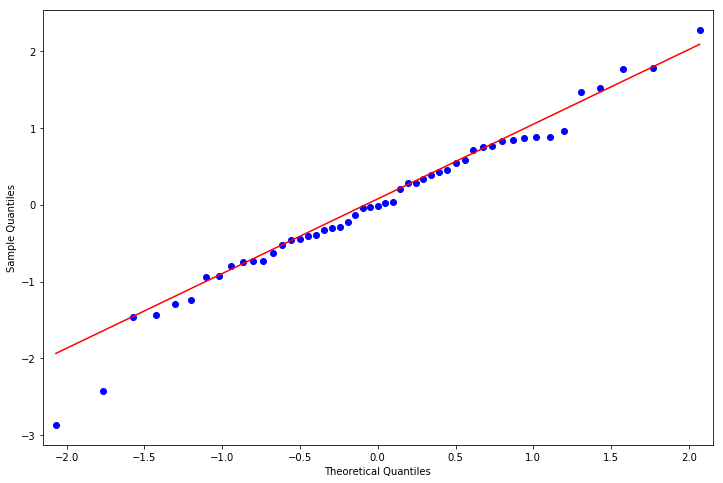

In [16]:
# DW test - auto correlation
print(sm.stats.durbin_watson(res.values)) #2.1038679569471332
# normality test
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(res, line='q', ax=ax, fit=True)

In [17]:
r,q,p = sm.tsa.acf(res.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.086685   0.406219  0.523895
2.0  -0.034472   0.471769  0.789872
3.0   0.225337   3.331140  0.343332
4.0   0.002379   3.331466  0.503962
5.0  -0.085028   3.756291  0.585010
6.0   0.268582   8.089264  0.231636
7.0   0.023896   8.124343  0.321757
8.0  -0.037344   8.212007  0.413040
9.0   0.022472   8.244508  0.509706
10.0 -0.131123   9.378003  0.496644
11.0 -0.081516   9.827027  0.546010
12.0  0.214324  13.010659  0.368266
13.0 -0.159639  14.823421  0.318506
14.0 -0.064541  15.127730  0.369479
15.0 -0.115335  16.126501  0.373694
16.0 -0.036901  16.231662  0.436913
17.0 -0.152600  18.082971  0.383625
18.0  0.028735  18.150605  0.445773
19.0  0.016666  18.174067  0.510840
20.0 -0.005836  18.177037  0.575747
21.0  0.032683  18.273278  0.631651
22.0 -0.076862  18.823925  0.656175
23.0 -0.146451  20.894419  0.587535
24.0  0.101932  21.934597  0.583171
25.0 -0.151567  24.322861  0.500787
26.0  0.018101  24.358285  0

2018-03    239.772505
2018-04    250.420116
2018-05    256.799162
2018-06    260.620885
2018-07    262.910502
2018-08    264.282224
2018-09    265.104031
2018-10    265.596381
2018-11    265.891350
2018-12    266.068068
2019-01    266.173941
2019-02    266.237370
2019-03    266.275370
Freq: M, dtype: float64


Text(0.5,1,'Forecast for 2018-04 to 2019-03 (ARMA[1,0])')

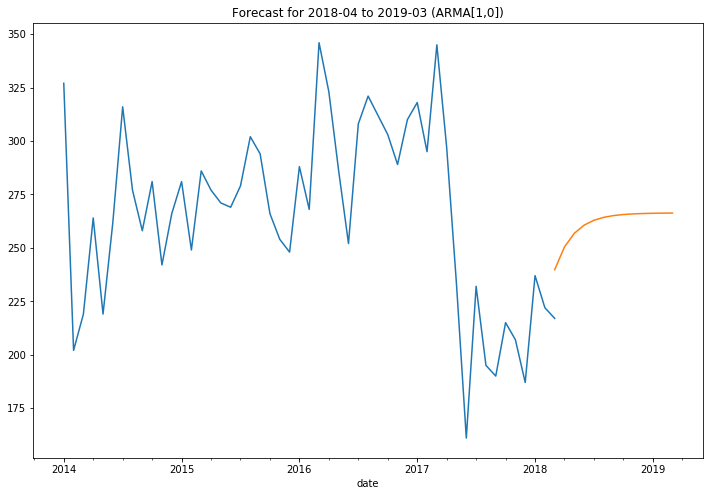

In [18]:
predict_sunspots = m_arma.predict('2018-03', '2019-03', dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts_M.ix['2014-01':].plot(ax=ax)
predict_sunspots.plot(ax=ax)
title('Forecast for 2018-04 to 2019-03 (ARMA[1,0])')

In [19]:
# seasonal model
m_seasonal = sm.tsa.statespace.SARIMAX(ts_M, trend='c', order=(1,0,0), seasonal_order=(1,0,0,12)) 
results = m_seasonal.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   51
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -250.280
Date:                            Sun, 12 Aug 2018   AIC                            508.560
Time:                                    22:27:24   BIC                            516.288
Sample:                                01-31-2014   HQIC                           511.513
                                     - 03-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.6038     25.482      1.397      0.162     -14.340      85.548
ar.L1          0.7362      0.118   

2018-04    215.713968
2018-05    201.205321
2018-06    178.750221
2018-07    220.898101
2018-08    209.685818
2018-09    211.955114
2018-10    227.197588
2018-11    225.924617
2018-12    218.310641
2019-01    243.332180
2019-02    237.237029
2019-03    235.609321
Freq: M, dtype: float64


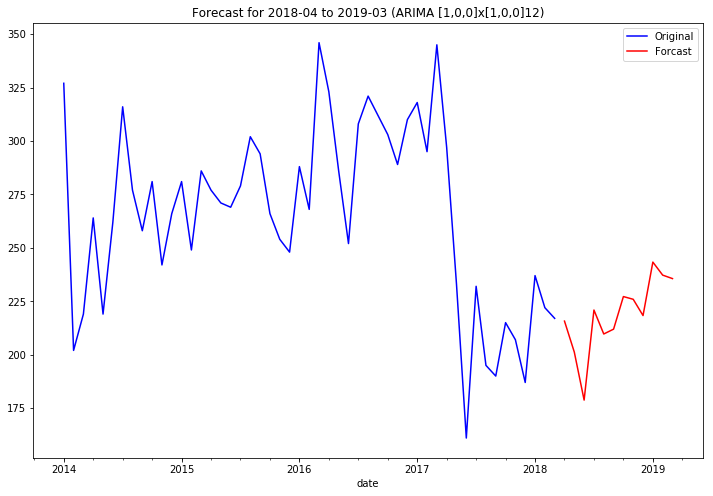

In [22]:
forecast = results.predict(start = '2018-04', end= '2019-03', dynamic= True)
print(forecast)
ts_M.plot(label='Original',color='blue',figsize=(12, 8))
forecast.plot( label='Forcast',color='red')
legend(loc='best')
title('Forecast for 2018-04 to 2019-03 (ARIMA [1,0,0]x[1,0,0]12)')
plt.savefig('arma.png')